# Using an Inference Service
In this notebook we're going to show how the inference server can be used to make predictions.<br>

Prior to using these examples, please deploy the Monkey Classification Inference Service in the other notebook.

Email ntl@us.ibm.com with questions

## License
Apache-2.0 License

In [16]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [17]:
import os
import aiohttp
import requests
import subprocess
import yaml
from typing import Dict
import base64
import json
import asyncio
import cv2
from matplotlib import pyplot as plt
import math
import time
import random

In [18]:
INFERENCE_SERVICE_NAME = "monkey-classification"

In [19]:
model_name = "monkey-classification"

## View the pods that the Inference Service has started

There should be one predictor pod and one transformer pod. The transformer converts the inputs and outputs to/from the formats expected by the predictor.

Our example uses Triton Inference service as the predictor backend.

In [20]:
!kubectl get pods -l serving.kserve.io/inferenceservice=$INFERENCE_SERVICE_NAME

NAME                                                              READY   STATUS    RESTARTS   AGE
monkey-classification-predictor-default-00001-deployment-5gxlwj   2/2     Running   0          8m51s
monkey-classification-transformer-default-00001-deploymentrsrr9   2/2     Running   0          8m51s


## Download some test images for classification

The images that are downloaded are of different sizes from each other and the training data. These are the images we will send to the inference service for classification.

In [21]:
!wget "https://upload.wikimedia.org/wikipedia/commons/0/00/Uakari_male.jpg" -O '/home/jovyan/Uakari.jpg' -q
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/Panamanian_Male_Adult_Howler_Monkey.jpg/256px-Panamanian_Male_Adult_Howler_Monkey.jpg" -O '/home/jovyan/Howler.jpg' -q
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Patas_monkey.jpg/256px-Patas_monkey.jpg" -O '/home/jovyan/Patas.jpg' -q
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Nilgiri_langur-3-mundanthurai-tirunelveli-India.jpg/640px-Nilgiri_langur-3-mundanthurai-tirunelveli-India.jpg?download" -O '/home/jovyan/Langur.jpg' -q
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d2/Macaca_fuscata_with_Castanea_crenata_01.JPG/400px-Macaca_fuscata_with_Castanea_crenata_01.JPG?download" -O '/home/jovyan/macaca.jpg' -q
!wget "https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Cebuella_pygmaea1.jpg/256px-Cebuella_pygmaea1.jpg" -O "/home/jovyan/pygmy_marmoset.jpg" -q

test_files = [
    "/home/jovyan/Uakari.jpg",
    "/home/jovyan/Howler.jpg",
    "/home/jovyan/Patas.jpg",
    "/home/jovyan/Langur.jpg",
    "/home/jovyan/macaca.jpg",
    "/home/jovyan/pygmy_marmoset.jpg",
]

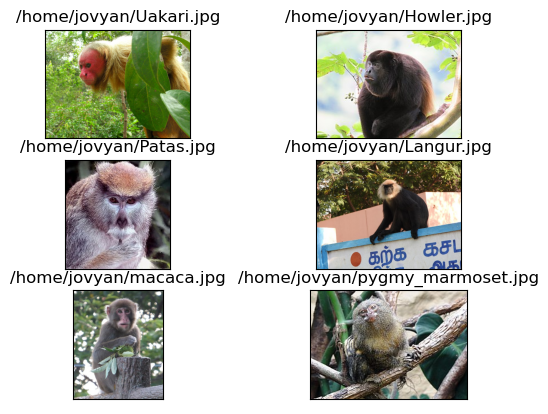

In [7]:
fig = plt.figure()
for i, f in enumerate(test_files):
    img = cv2.imread(f)
    ax = fig.add_subplot(math.ceil(len(test_files) / 2), 2, i + 1)
    ax.title.set_text(f"{f}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_aspect(1)
plt.show()

## The inference service resource tells us valuable information about the service

We'll run the kubectl command using a python function, the returned yaml is parsed and stored in a variable for later use.

In [22]:
r = subprocess.run(
    ["kubectl", "get", "InferenceService", INFERENCE_SERVICE_NAME, "-oyaml"],
    stdout=subprocess.PIPE,
    check=True,
    text=True,
)
inference_service = yaml.safe_load(r.stdout)

### The service provides both a predictor and a transformer

The predictor does the inference using the model(s). Our predictor has been allocated a GPU by Kubernetes.

In [23]:
inference_service["spec"]["predictor"]["model"]["resources"]["limits"]

{'nvidia.com/gpu': '1'}

The transformer transforms inputs into the tensors that are sent to the predictor. It transforms the output of the model into a json response.

The transformer has it's code in a container image.

In [24]:
inference_service["spec"]["transformer"]["containers"][0]["image"]

'quay.io/ntlawrence/monkeytransform:latest'

## The Inference service is accessed by a URL
There is a URL for accessing the inference service internally within the cluster

In [25]:
internal_url = inference_service["status"]["address"]["url"]
print(internal_url)

http://monkey-classification.kubeflow-ntl.svc.cluster.local/v2/models/monkey-classification/infer


There is also a URL for accessing the inference service from outside of the cluster. Our environment is not setup to allow this URL to be used, enabling external access has security implications.

By default, this might have a domain of 'example.com', if you really want to expose this with a custom domain name, the directions to set the domain name are here: https://knative.dev/docs/serving/using-a-custom-domain/

In [26]:
service_host_name = inference_service["status"]["url"]
print(service_host_name)

http://monkey-classification.kubeflow-ntl.example.com


## Make predictions
The cells bellow will submit the test files to the inference service async. The returned predictions are gathered and printed.

The transformer will take we send it, and create an inference request for the predictor. The transformer will then take the predictor's response, and create the response that we see from these cells.

In [27]:
async def predict(endpoint: str, file_path: str):
    with open(file_path, "rb") as image_file:
        image = image_file.read()

    # format of this request is defined by the transformer
    headers = {"Content-Type": "application/json"}
    payload = {"instance": {"image": base64.b64encode(image).decode("utf-8")}}

    # submit request async
    start = time.time()
    async with aiohttp.ClientSession() as session:
        async with session.post(endpoint, headers=headers, json=payload) as res:
            return {
                "file": file_path,
                "response": await res.text(),
                "seconds": time.time() - start,
            }

In [28]:
# Submit request for each test file and display the response data
pending = [asyncio.create_task(predict(internal_url, f)) for f in test_files]

while pending:
    done, pending = await asyncio.wait(pending, return_when=asyncio.FIRST_COMPLETED)
    for d in done:
        r = d.result()
        print("------")
        print(f'Response for file {r["file"]} in {r["seconds"]:.2f} seconds:')
        print(json.dumps(json.loads(r["response"]), indent=2))

------
Response for file /home/jovyan/pygmy_marmoset.jpg in 0.75 seconds:
{
  "predictions": [
    {
      "Pygmy marmoset (Cebuella pygmaea)": 0.9992073178291321,
      "Black headed night monkey (Aotus nigriceps)": 0.0005997319240123034,
      "Mantled howler (Alouatta palliata)": 7.698730769334361e-05,
      "Japanese macaque (Macaca fuscata)": 4.4864991650683805e-05,
      "Bald uakari (Cacajao calvus)": 2.8798087441828102e-05,
      "Silvery marmoset (Mico argentatus)": 2.118649717886001e-05,
      "Nilgiri langur (Trachypithecus johnii)": 1.2072819117747713e-05,
      "Colombian white-faced capuchin (Cebus capucinus)": 4.751505002786871e-06,
      "Common squirrel monkey (Saimiri sciureus)": 2.969397655760986e-06,
      "Patas monkey (Erythrocebus patas)": 1.3043406852375483e-06
    }
  ]
}
------
Response for file /home/jovyan/Patas.jpg in 0.77 seconds:
{
  "predictions": [
    {
      "Patas monkey (Erythrocebus patas)": 0.9997901320457458,
      "Japanese macaque (Macaca fusca

### Load Test
This next cell creates a stream of 16 parallel requests to the inference service over several minutes.

To watch the pods scale up, you can start a terminal, and use the command:
`kubectl get pods -l serving.kserve.io/inferenceservice=monkey-classification`

If the service is idle for a significant length of time, it will scale back down. 

Prometheus and Grafana can be used to monitor the performance and utilization of the inference services, however these tools are not currently installed on the cluster.

The cell displays a running count of responses.

In [ ]:
random.seed(12345)


def mygenerator(l):
    while True:
        f = l[random.randrange(len(l))]
        yield f


LIST_SIZE = 16
FOUR_MIN = 240
start = time.time()
g = mygenerator(test_files)
pending = [
    asyncio.create_task(predict(internal_url, next(g))) for _ in range(LIST_SIZE)
]
images_processed = 0
while time.time() - start < FOUR_MIN:
    done, pending = await asyncio.wait(pending, return_when=asyncio.FIRST_COMPLETED)
    pending = pending.union(
        [asyncio.create_task(predict(internal_url, next(g))) for _ in range(len(done))]
    )
    images_processed += len(done)
    print(
        f"{images_processed} processed at a rate of {images_processed / (time.time() - start):.2f} per second (after {int(time.time() - start)} seconds)".ljust(
            150
        ),
        end="\r",
    )